### Copyright (C) 2022 Sobhan Moradian Daghigh and s.o who's unknown :)
### Date: 2/20/2022 

In [214]:
from amalearn.reward import RewardBase
from amalearn.agent import AgentBase
from amalearn.environment import EnvironmentBase
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import numpy as np
import gym

In [572]:
class Environment(EnvironmentBase):
    
    obstacles = [(1, 7), (1, 8), (2, 7), (2, 8), (3, 7), (3, 8), (4, 7), (4, 8),
                (12, 6), (12, 7), (13, 6), (13, 7), (14, 6), (14, 7), (15, 6), (15, 7),
                (8, 13), (8, 14), (8, 15), (9, 13), (9, 14), (9, 15)]
    
    def __init__(self, actionPrice, goalReward, punish, obstacles=obstacles, i_limit=15, j_limit=15, p=0.8, goal=(1, 1), start=(15, 15), container=None):
        """ initialize your variables """
        
        state_space = gym.spaces.MultiDiscrete([i_limit, j_limit])
        action_space = gym.spaces.Discrete(9)
        super(Environment, self).__init__(action_space, state_space, container)
        self.state_space = state_space
        self.obstacles = obstacles
        self.actionPrice = actionPrice
        self.goalReward = goalReward
        self.punish = punish
        self.i_limit = i_limit
        self.j_limit = j_limit
        self.p = p
        self.goal = goal
        self.start = start
        self.state = start
        self.state_p = None
        
        
    # -------------------------------------------------------------------------------------------------------------    
    def isStatePossible(self, state):
        """if given state is possible (not out of the grid and not obstacle) return ture"""
        
        i_in = range(1, self.i_limit + 1)
        j_in = range(1, self.j_limit + 1)
        
        return False if state in self.obstacles or state[0] not in i_in or state[1] not in j_in else True
    
    
    # -------------------------------------------------------------------------------------------------------------
    def isAccessible(self, state, state_p):
        """if given state is Accesible (we can reach state_p by doing an action from state) return true"""

        if self.isStatePossible(state) and self.isStatePossible(state_p):
            if (np.abs(np.subtract(state, state_p)) <= (1, 1)).all():
                return True
        return False
    
    
    # -------------------------------------------------------------------------------------------------------------
    def getTransitionStatesAndProbs(self, state, action, state_p):
        """return probability of transition or T(sp,a,s)"""

        _, actions = self.available_actions(state)
        if action in actions:
            available_states = self.available_states(actions, state)
            
            if self.next_state(action, state) == state_p:
                return self.p
            
            elif state_p in available_states:
                return (1 - self.p) / (len(available_states) - 1)
            
            else: return 0
        
        else: return 0
    
    # -------------------------------------------------------------------------------------------------------------
    def getReward(self, state, action, state_p):
        """return reward of transition"""
        
        # The Goal Achieved
        if state_p == self.goal:
            return self.goalReward
        
        elif self.isAccessible(state, state_p):
            return self.actionPrice
        
        # Hit the obstacles
        else:
            return self.punish
        
            
    # -------------------------------------------------------------------------------------------------------------
    def calculate_reward(self, action):
#         probabilities = []
#         for i in range(-1, 2):
#             for j in range(-1, 2):
#                 state_p = self.next_state((i, j), self.state)
#                 probabilities.append(self.getTransitionStatesAndProbs(self.state, action, state_p))
        
#         _, available_actions = self.available_actions(self.state)
#         move = available_actions[np.random.choice(len(available_actions), p=list(filter(lambda num: num != 0, probabilities)))]
#         self.state_p = tuple(np.add(move, self.state))
#         return self.state_p
        pass
    
    # -------------------------------------------------------------------------------------------------------------
    def terminated(self, state):
        return state == self.goal
    
    
    # -------------------------------------------------------------------------------------------------------------
    def available_actions(self, state):
        actions = []
        numbers = []
        num = 0
        for i in range(-1, 2):
            for j in range(-1, 2):
                state_p = tuple(np.add(state, (j, i)))
                if self.isAccessible(state, state_p):
                    actions.append((j, i))
                    numbers.append(num)
                num += 1
                    
        return numbers, actions
    
    
    # -------------------------------------------------------------------------------------------------------------
    def action_num2dim(self, num):
        if num < 3:
            return (np.mod(num, 3) -1, -1)
        elif num < 6:
            return (np.mod(num, 3) -1, 0)
        else:
            return (np.mod(num, 3) -1, 1)
        
        
    # -------------------------------------------------------------------------------------------------------------
    def get_states(self):
        states = []
        for i in range(self.i_limit + 1, 0, -1):
            for j in range(self.j_limit + 1, 0, -1):
                if self.isStatePossible((i, j)):
                    states.append((i, j))
        return states
    
    
    # -------------------------------------------------------------------------------------------------------------
    def available_states(self, actions, state):
        states_p = []
        for action in actions:
            states_p.append(self.next_state(action, state))
        return states_p
                
    
    # -------------------------------------------------------------------------------------------------------------
    def next_state(self, action, state):
        return tuple(np.add(state, action))

    
    # -------------------------------------------------------------------------------------------------------------
    def reset(self):
        self.state = self.start
        
        
    # -------------------------------------------------------------------------------------------------------------
    def observe(self):
        return self.state
    
    
    # -------------------------------------------------------------------------------------------------------------
    def render(self):
        return 
    
    
    # -------------------------------------------------------------------------------------------------------------
    def close(self):
        return
    

In [585]:
class Agent(AgentBase):
    def __init__(self, environment, theta=0.1, discount=0.9):
        #initialize a random policy and V(s) = 0 for each state
        self.environment = environment

        self.width  = self.environment.i_limit
        self.height = self.environment.j_limit
        
        #init V
        self.V = [[0.0] * (self.width + 1) for _ in range(self.height + 1)]
        
        #init policy
        self.policy = np.random.randint(0, 9, (self.width + 1, self.height + 1))
        
        super(Agent, self).__init__(id, environment)
        self.discount = discount
        self.theta = theta
        
    
    # -------------------------------------------------------------------------------------------------------------
    def policy_evaluation(self):        
        while True:
            delta = 0.01 #TODO
            pre_delta = delta
            for state in self.environment.get_states():
                v = self.V[state[0]][state[1]]                
                action = self.policy[state[0]][state[1]]                
                numbers, actions = self.environment.available_actions(state)
                value = 0
                for act in actions:
                    state_p = self.environment.next_state(act, state)
                    reward = self.environment.getReward(state, action_num2dim(action), state_p)
                    probability = self.environment.getTransitionStatesAndProbs(state, action_num2dim(action), state_p)
                    value += probability * (reward + self.discount * self.V[state_p[0]][state_p[1]])

                self.V[state[0]][state[1]] = value
                delta = max([delta, np.abs(v - self.V[state[0]][state[1]])])

            if delta < self.theta or delta == pre_delta:
                break
                
            pre_delta = delta
                
        return self.V
                    
        
    # -------------------------------------------------------------------------------------------------------------
    def policy_improvement(self):
        unchanged = False
        for state in self.environment.get_states():
            pre_action = self.policy[state[0]][state[1]]
            acts = []
            numbers, actions = self.environment.available_actions(state)
            for _, act1 in zip(numbers, actions):
                value = 0
                for _, act2 in zip(numbers, actions):
                    state_p = self.environment.next_state(act2, state)
                    reward = self.environment.getReward(state, act1, state_p)                    
                    probability = self.environment.getTransitionStatesAndProbs(state, act1, state_p)
                    value += probability * (reward + self.discount * self.V[state_p[0]][state_p[1]])
                acts.append(value)
            best_act = np.argmax(acts)
            self.policy[state[0]][state[1]] = numbers[best_act]
            
            if numbers[best_act] == pre_action:
                unchanged = True
        return unchanged
    
    
    # -------------------------------------------------------------------------------------------------------------
    def policy_iteration(self):
        unchanged = False
        while not unchanged:
            self.V = self.policy_evaluation()
            unchanged = self.policy_improvement()
    
    
    # -------------------------------------------------------------------------------------------------------------
    def take_action(self) -> (object, float, bool, object):
        self.policy_iteration()
                    
    
    # -------------------------------------------------------------------------------------------------------------
    def visualize_policy(self):
        
        fig, ax = plt.subplots()
        policy = self.policy[1:, 1:].T

        ax.matshow(policy, cmap='summer')
        for i in range(self.width):
            for j in range(self.height):
                c = policy[i, j]
                ax.text(i, j, str(c), va='center', ha='center')
        plt.axis('off')
        plt.show()
        
    # -------------------------------------------------------------------------------------------------------------
    def get_path(self):
        path = []
        states = []
        start = self.environment.start
        curr = start
        while True:
            num = self.policy[curr[0]][curr[1]]
            path.append(num)
            states.append(curr)
            direction = self.environment.action_num2dim(num)
            curr = tuple(np.add(curr, direction))
            if self.environment.terminated(curr):
                break
        return path, states[1:]

In [601]:
def plotter(environment, agent):
    plt.gcf().set_size_inches(10, 10)
    
    plt.gca().set_xticks(range(1, environment.i_limit + 1))
    plt.gca().set_yticks(range(environment.j_limit, 0, -1))

#     path, states = agent.get_path()
    no = 1
    for i in range(environment.i_limit, 0, -1):
        temp = (environment.i_limit + 1) - i
        for j in range(environment.j_limit, 0, -1):
            if (i, j) == environment.start:
                plt.gca().text(j - 0.5, temp - 0.5, str(no), va='center', ha='center')
                plt.gca().add_patch(Rectangle((j, temp), -1, -1, fill=True, color='purple', alpha=0.5))
                no += 1
            
            if (i, j) in environment.obstacles:
                plt.gca().add_patch(Rectangle((j, temp), -1, -1, fill=True, color='black', alpha=0.5))
                
#             elif (i, j) in states:
#                 num = path[states.index((i, j))]
#                 direction = environment.action_num2dim(num)
                
#                 plt.gca().text(j - 0.5, temp - 0.5, str(no), va='center', ha='center')
#                 plt.gca().add_patch(Rectangle((j, temp), -1, -1, fill=True, color='blue', alpha=0.5))
#                 no += 1
                
            elif (i, j) == environment.goal:
                plt.gca().text(j - 0.5, temp - 0.5, str(no), va='center', ha='center')
                plt.gca().add_patch(Rectangle((j, temp), -1, -1, fill=True, color='green', alpha=0.5))

    plt.grid(True)
    plt.show()

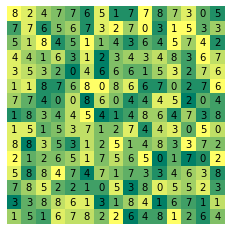

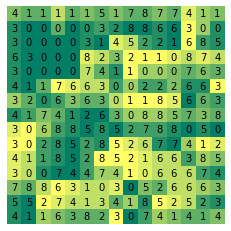

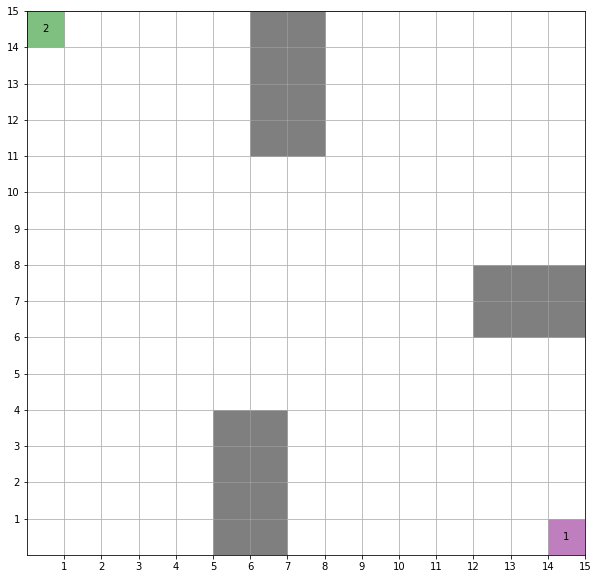

In [602]:
environment = Environment(actionPrice = -0.01, goalReward= 1000, punish = -1, i_limit=15, j_limit=15, start=(15, 15))
agent = Agent(environment, theta=10)
agent.visualize_policy()
agent.take_action()
agent.visualize_policy()
plotter(environment, agent)

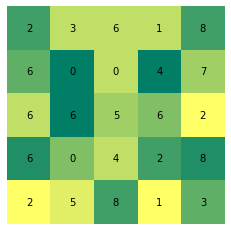

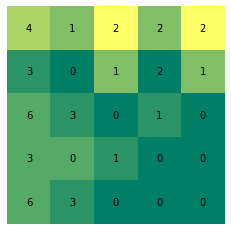

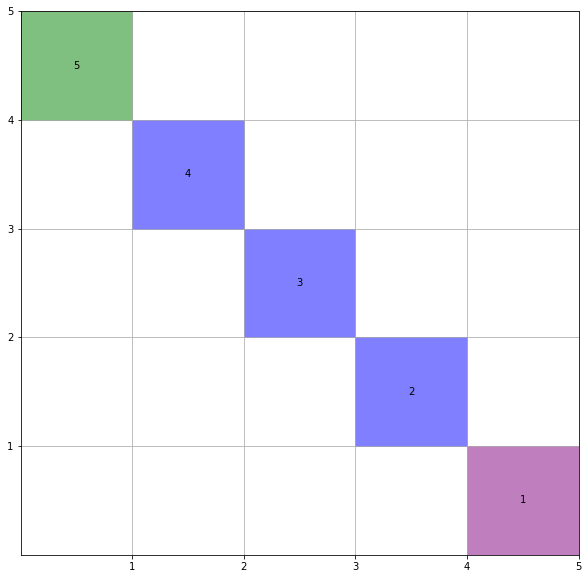

In [588]:
environment = Environment(actionPrice = -0.01, goalReward= 1000, punish = -1, i_limit=5, j_limit=5, start=(5, 5))
agent = Agent(environment, theta=0)
agent.visualize_policy()
agent.take_action()
agent.visualize_policy()
plotter(environment, agent)

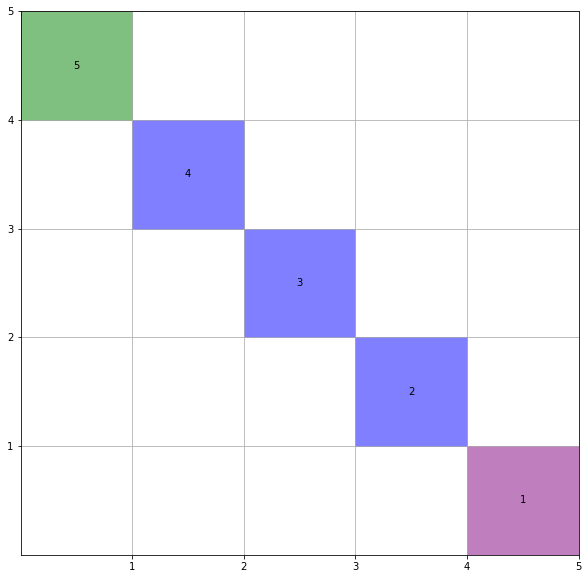

In [589]:
plotter(environment, agent)